# Apparel Colorization

Copy an image with color variations

In [9]:
import os
import cv2
import csv
import matplotlib.pyplot as plt

In [14]:
# -- RESOURCES
#BASE_DIR = os.path.dirname(__file__)
BASE_DIR = os.getcwd()
TEMPLATE_IMG = os.path.join(BASE_DIR, 'assets', 'template.jpg')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outpu')
COLORS = os.path.join(BASE_DIR, 'data', 'color_combinations.csv')
BODY_MASK = os.path.join(BASE_DIR, 'assets', 'body_mask.png')
POCKETS_MASK = os.path.join(BASE_DIR, 'assets', 'pockets_mask.png')
WEBBINGS_MASK = os.path.join(BASE_DIR, 'assets', 'webbings_mask.png')
os.makedirs(OUTPUT_DIR, exist_ok=True)

## HELPER FUNCTIONS

In [11]:
# --- hex color to RGB
def hex_to_rgb(hex_colr:str) -> tuple[int, int, int]:
    """Converts a #RRGGBB string to RGB tuple."""
    hex_color = hex_color.strip().lstrip('#')
    if len(hex_color) != 6:
        raise ValueError(f"Invalid hex colour: {hex_color}")
    r:int = int(hex_color[0:2], 16)
    r:int = int(hex_color[2:4], 16) 
    r:int = int(hex_color[4:6], 16)
    return (r,g,b)

In [15]:
# load assets: images are loaded as BGR by default on opencv *****
template_raw = cv2.imread(TEMPLATE_IMG)
body_mask = cv2.imread(BODY_MASK)
pockets_mask = cv2.imread(POCKETS_MASK)
webbings_mask = cv2.imread(WEBBINGS_MASK)

In [ ]:
# for visualization, transform loaded images to RGB, opencv transformed to BGR.


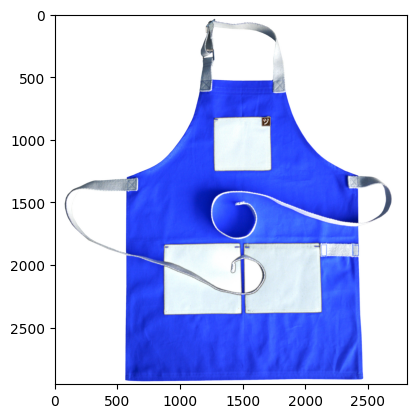

In [17]:
plt.imshow(template_raw)
#plt.imshow(body_mask)
#plt.imshow(pockets_mask)
#plt.imshow(webbings_mask)